# 01 — Exploratory Data Analysis

> **Goal:** Understand the raw transaction data before any modelling. Good EDA is the foundation of every good data science project.

This notebook covers:
- Dataset overview and data quality checks
- Revenue and transaction trends over time
- Product category performance
- Customer purchase behaviour distributions

In [1]:
import os, sys
os.chdir(r'C:\Users\mohit\Downloads\retail-customer-intelligence')
sys.path.insert(0, r'C:\Users\mohit\Downloads\retail-customer-intelligence')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Consistent style throughout project
plt.rcParams.update({'figure.dpi': 120, 'font.family': 'DejaVu Sans', 'axes.spines.top': False, 'axes.spines.right': False})
sns.set_palette("Blues_d")

# Load data
transactions = pd.read_csv('data/raw/transactions.csv', parse_dates=['date'])
products     = pd.read_csv('data/raw/products.csv')
customers    = pd.read_csv('data/raw/customers.csv')

print("=== Dataset Overview ===")
print(f"Transactions : {len(transactions):,}")
print(f"Customers    : {transactions['customer_id'].nunique():,}")
print(f"Products     : {transactions['product_id'].nunique():,}")
print(f"Date range   : {transactions['date'].min().date()} → {transactions['date'].max().date()}")
print(f"Total revenue: £{transactions['revenue'].sum():,.2f}")
print(f"\nMissing values:\n{transactions.isnull().sum()}")


=== Dataset Overview ===
Transactions : 80,000
Customers    : 3,469
Products     : 197
Date range   : 2025-02-22 → 2026-02-21
Total revenue: £2,489,518.40

Missing values:
transaction_id    0
customer_id       0
product_id        0
date              0
quantity          0
price             0
revenue           0
dtype: int64


## Revenue Trend Over Time

Looking at daily and monthly revenue helps identify seasonality — important for a pharmacy/beauty retailer like Boots where Christmas, Valentine's Day and summer all drive different spending.

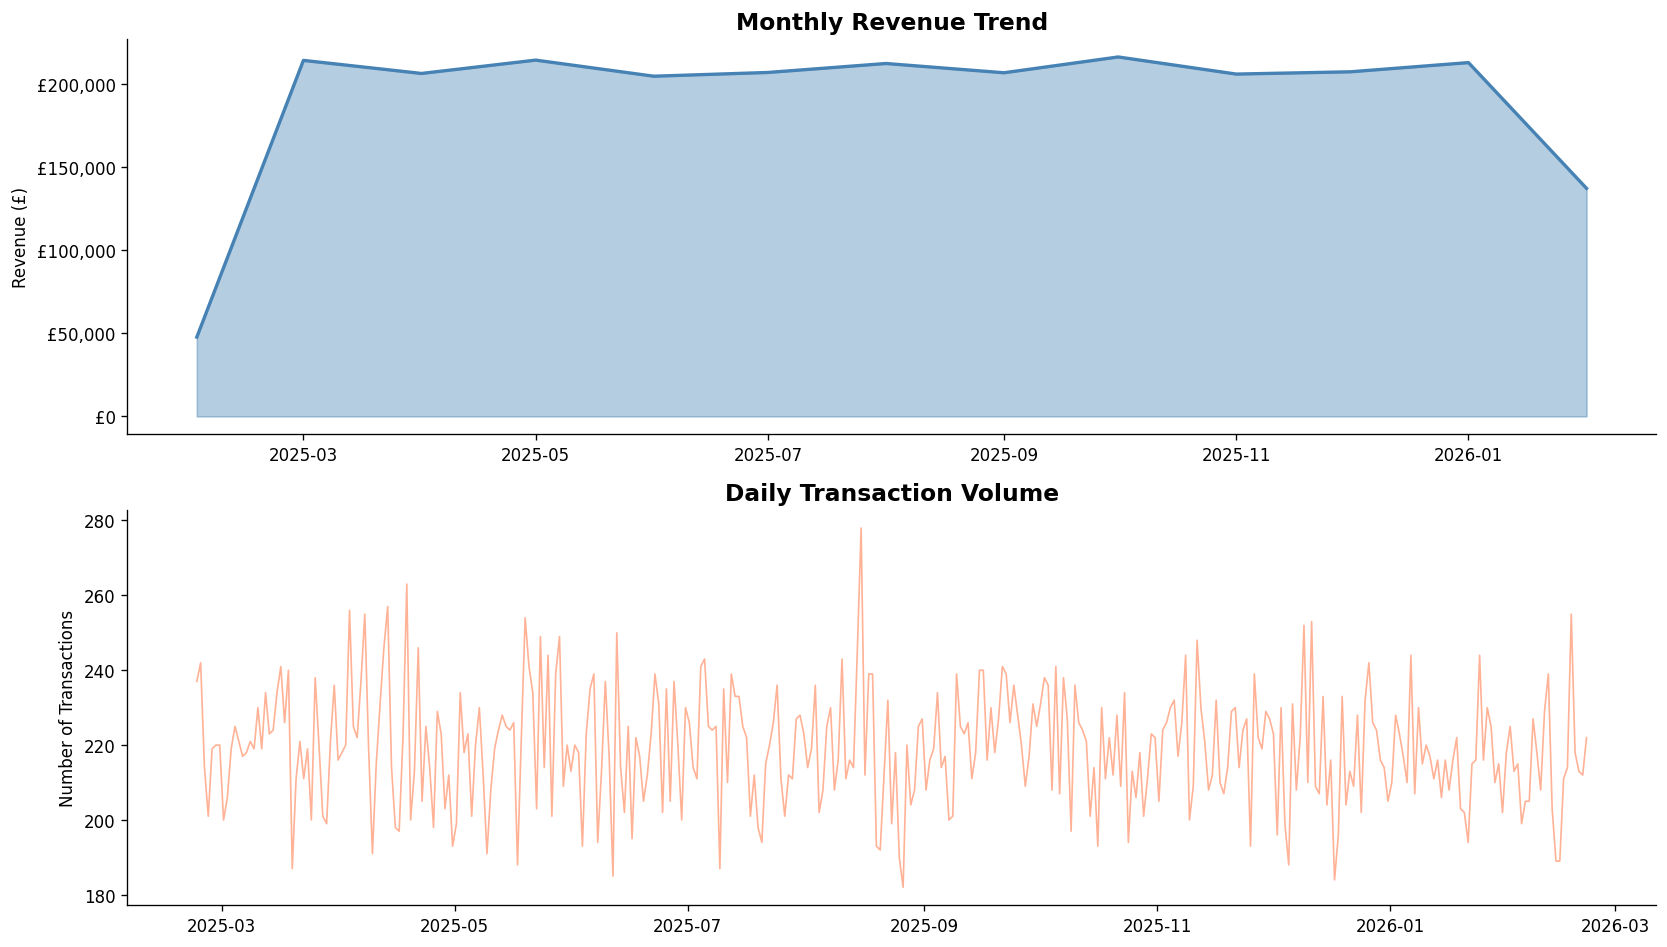

Saved: reports/figures/01_revenue_trend.png


In [2]:
# Monthly revenue trend
monthly = transactions.groupby(transactions['date'].dt.to_period('M'))['revenue'].sum().reset_index()
monthly['date'] = monthly['date'].dt.to_timestamp()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Monthly revenue
axes[0].fill_between(monthly['date'], monthly['revenue'], alpha=0.4, color='steelblue')
axes[0].plot(monthly['date'], monthly['revenue'], color='steelblue', linewidth=2)
axes[0].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Revenue (£)')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'£{x:,.0f}'))

# Daily transaction volume
daily_vol = transactions.groupby('date')['transaction_id'].count()
axes[1].plot(daily_vol.index, daily_vol.values, alpha=0.6, color='coral', linewidth=1)
axes[1].set_title('Daily Transaction Volume', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.savefig('reports/figures/01_revenue_trend.png', bbox_inches='tight')
plt.show()
print("Saved: reports/figures/01_revenue_trend.png")


## Product Category Analysis

Understanding which categories drive revenue informs both the recommendation engine (what to push) and segmentation (what customers buy).

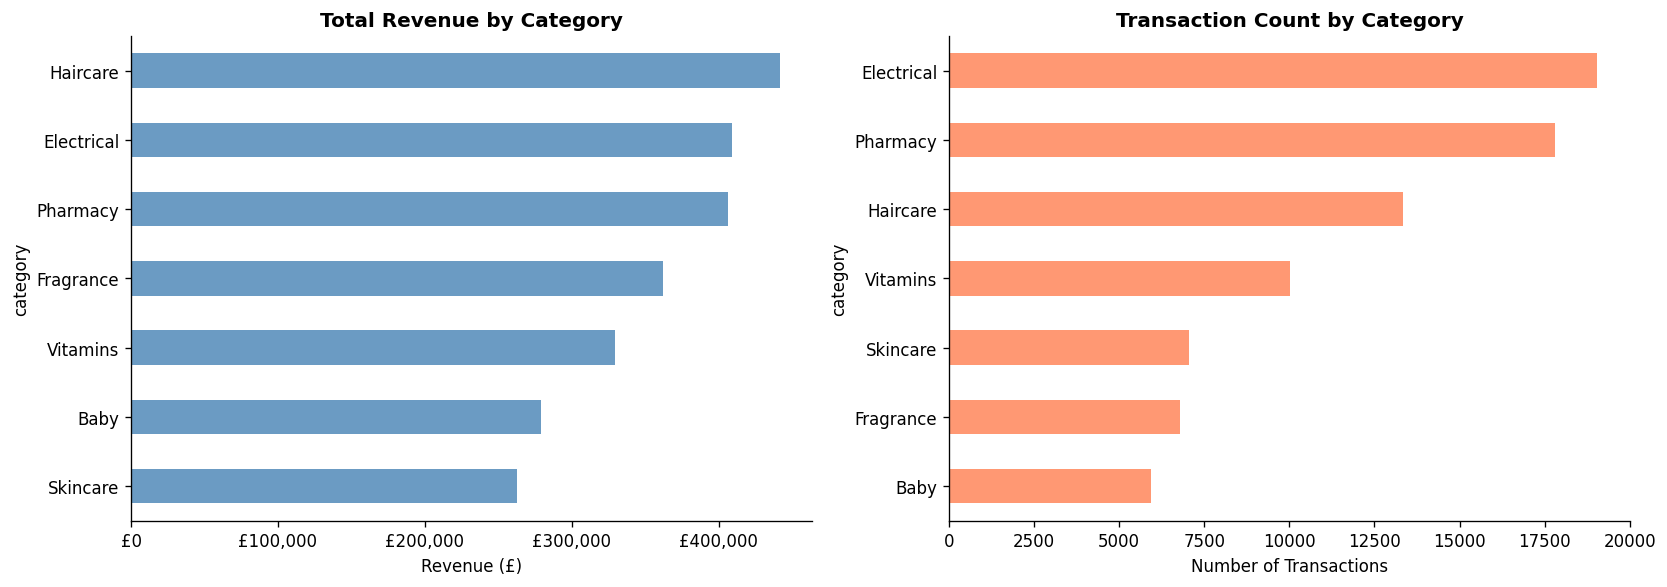

In [3]:
# Merge category info
df = transactions.merge(products[['product_id','category','price']], on='product_id')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Revenue by category
cat_rev = df.groupby('category')['revenue'].sum().sort_values(ascending=True)
cat_rev.plot(kind='barh', ax=axes[0], color='steelblue', alpha=0.8)
axes[0].set_title('Total Revenue by Category', fontweight='bold')
axes[0].set_xlabel('Revenue (£)')
axes[0].xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'£{x:,.0f}'))

# Transaction count by category
cat_count = df.groupby('category')['transaction_id'].count().sort_values(ascending=True)
cat_count.plot(kind='barh', ax=axes[1], color='coral', alpha=0.8)
axes[1].set_title('Transaction Count by Category', fontweight='bold')
axes[1].set_xlabel('Number of Transactions')

plt.tight_layout()
plt.savefig('reports/figures/01_category_analysis.png', bbox_inches='tight')
plt.show()


## Customer Purchase Behaviour

Retail data is almost always heavily skewed — a small number of customers drive most of the revenue (the classic Pareto principle / 80-20 rule). Understanding this is key to segmentation.

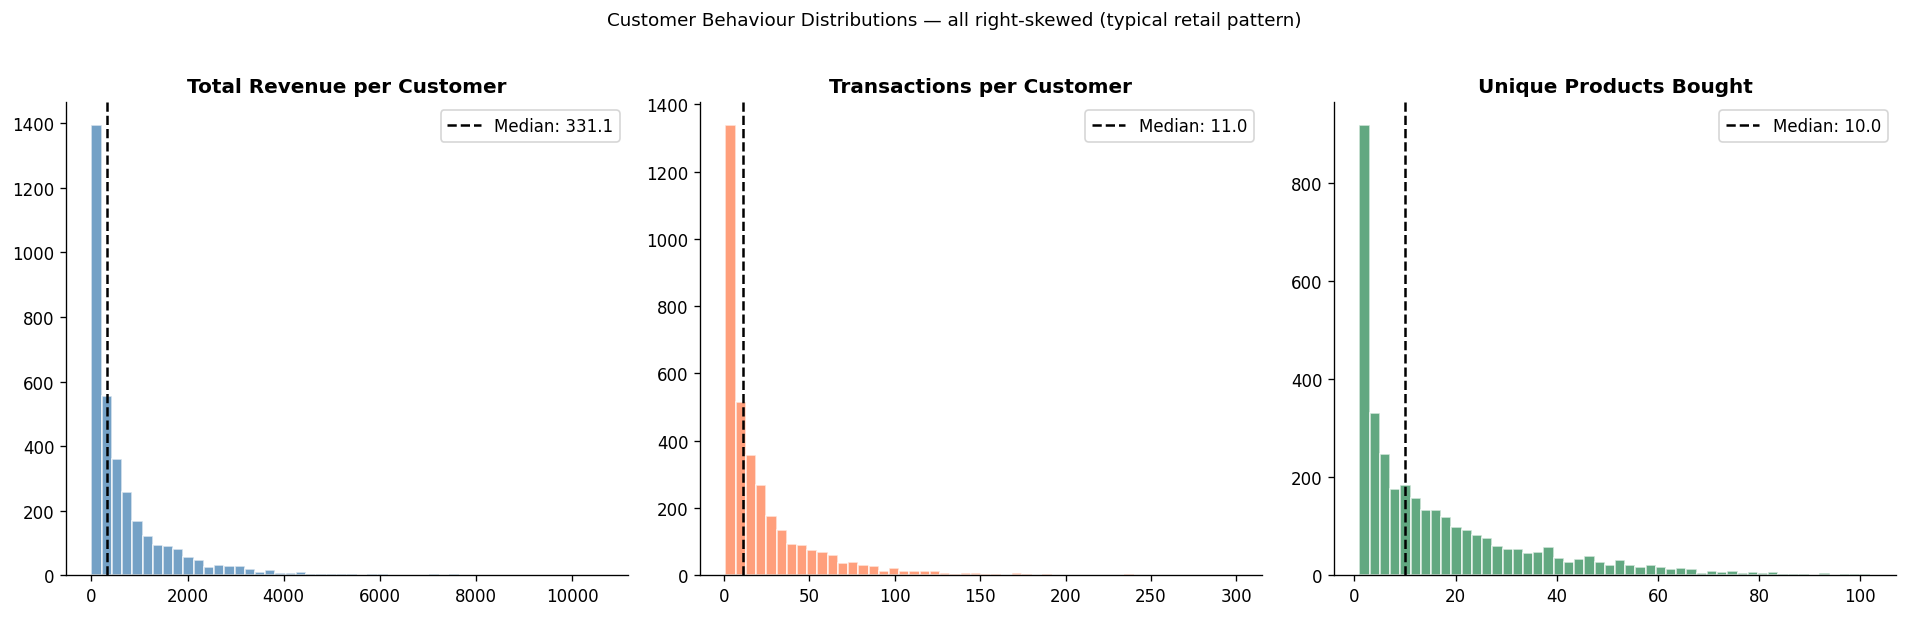

In [4]:
customer_stats = transactions.groupby('customer_id').agg(
    total_revenue=('revenue','sum'),
    n_transactions=('transaction_id','nunique'),
    n_products=('product_id','nunique')
).reset_index()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, col, title, color in zip(axes,
    ['total_revenue', 'n_transactions', 'n_products'],
    ['Total Revenue per Customer', 'Transactions per Customer', 'Unique Products Bought'],
    ['steelblue', 'coral', 'seagreen']):
    ax.hist(customer_stats[col], bins=50, color=color, alpha=0.75, edgecolor='white')
    ax.set_title(title, fontweight='bold')
    ax.axvline(customer_stats[col].median(), color='black', linestyle='--', linewidth=1.5, label=f'Median: {customer_stats[col].median():.1f}')
    ax.legend()

plt.suptitle('Customer Behaviour Distributions — all right-skewed (typical retail pattern)', fontsize=11, y=1.02)
plt.tight_layout()
plt.savefig('reports/figures/01_customer_distributions.png', bbox_inches='tight')
plt.show()


## Pareto Analysis

Confirming the 80/20 rule: what % of customers generate 80% of revenue?

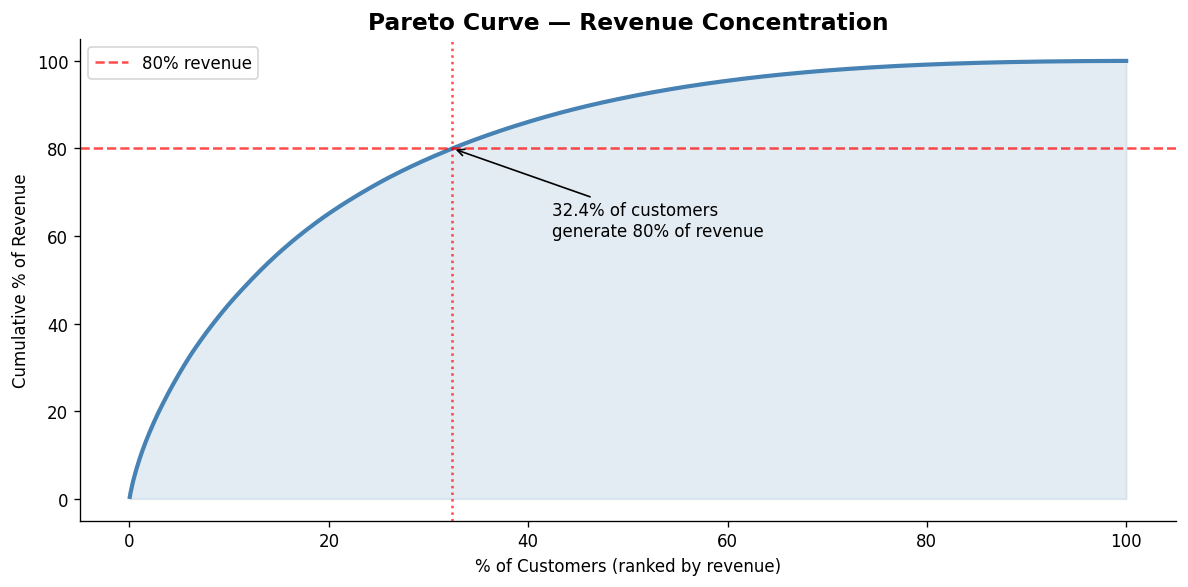


Key insight: Top 32.4% of customers generate 80% of revenue
This justifies a targeted segmentation strategy — not all customers need the same treatment.


In [5]:
# Pareto curve
rev_sorted = customer_stats['total_revenue'].sort_values(ascending=False).reset_index(drop=True)
cumulative  = rev_sorted.cumsum() / rev_sorted.sum() * 100
pct_customers = (rev_sorted.index + 1) / len(rev_sorted) * 100

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pct_customers, cumulative, color='steelblue', linewidth=2.5)
ax.axhline(80, color='red', linestyle='--', alpha=0.7, label='80% revenue')
ax.fill_between(pct_customers, cumulative, alpha=0.15, color='steelblue')
ax.set_xlabel('% of Customers (ranked by revenue)')
ax.set_ylabel('Cumulative % of Revenue')
ax.set_title('Pareto Curve — Revenue Concentration', fontsize=14, fontweight='bold')
ax.legend()

# Find 80% point
idx_80 = (cumulative >= 80).idxmax()
pct_at_80 = pct_customers[idx_80]
ax.axvline(pct_at_80, color='red', linestyle=':', alpha=0.7)
ax.annotate(f'{pct_at_80:.1f}% of customers\ngenerate 80% of revenue',
            xy=(pct_at_80, 80), xytext=(pct_at_80+10, 60),
            arrowprops=dict(arrowstyle='->', color='black'), fontsize=10)

plt.tight_layout()
plt.savefig('reports/figures/01_pareto.png', bbox_inches='tight')
plt.show()
print(f"\nKey insight: Top {pct_at_80:.1f}% of customers generate 80% of revenue")
print("This justifies a targeted segmentation strategy — not all customers need the same treatment.")


## EDA Summary

| Finding | Implication |
|---------|-------------|
| Revenue is seasonal | Time-based features matter for modelling |
| Skincare & Pharmacy dominate revenue | Recommendation engine should weight these |
| Purchase frequency is heavily skewed | Most customers are low-frequency — RFM needed |
| ~20% customers → 80% revenue | Segmentation will reveal high-value vs at-risk groups |

**Next:** → `02_Customer_Segmentation_RFM.ipynb`